# Black Oil Table Extension
## Based on approach outlined in SPE 109596, with following modifications
1. Extrapolating Rs and Rv with quadratic equations in log-log space, honoring last slopes seen in table data



In [1]:
%matplotlib inline
import pandas as pd
from scipy import interpolate
import matplotlib.pyplot as plt
import math
from scipy.stats import linregress
from sympy import symbols, Eq, solve
import tabulate
from tabulate import tabulate
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize
from scipy.optimize import fsolve
import numpy.polynomial.polynomial as poly
from os import system, name 
from IPython.display import clear_output

def log10(x):
    return math.log(x)/math.log(10)

R = 10.73146 # Universal gas constant, psia-ft3/R-lbm mol

In [2]:
sheet_name = 'PVTO&PVTG_example.xlsx'
dfPVTO = pd.read_excel (sheet_name, sheet_name='PVTO')
dfPVTG = pd.read_excel (sheet_name, sheet_name='PVTG')

## Lets take a look at it

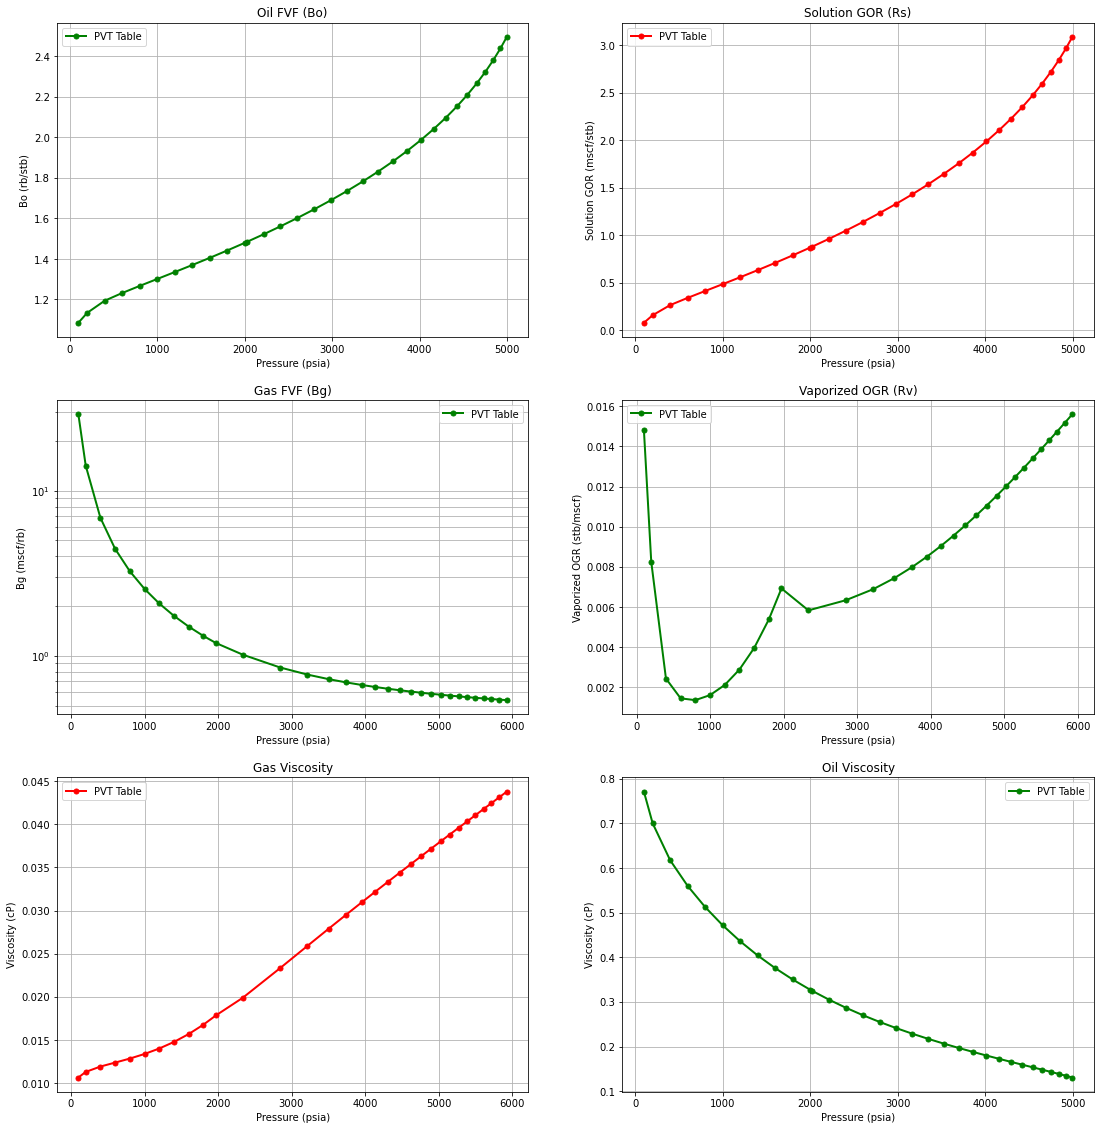

In [29]:
nx, ny = [2,3]
dxs, dys = [8.0, 5.5]                                                                                                                               
i = j = 0
fig, ax = plt.subplots(ny, nx, sharey = False, figsize=(dxs*nx, dys*ny), squeeze=False ) # squeeze = False ensures 2 x 1 does not get converted to 1D                                                                                
fig.subplots_adjust(top=0.95, bottom = 0.05, left = 0.05, right = 0.95)   

ax[i,j].title.set_text('Oil FVF (Bo)')
ax[i,j].plot(dfPVTO['Pb'], dfPVTO['Bo'], label='PVT Table', color='green', linewidth=2,marker='o',markersize=5)  
ax[i,j].grid(True, which="both")                                                                                                              
ax[i,j].set_xlabel('Pressure (psia)')                                                                                        
ax[i,j].set_ylabel('Bo (rb/stb)')                                                                                                    
ax[i,j].legend() 

i, j = nextplot(i,j,nx)
ax[i,j].title.set_text('Solution GOR (Rs)')
ax[i,j].plot(dfPVTO['Pb'], dfPVTO['Rs'], label='PVT Table', color='red', linewidth=2,marker='o',markersize=5)  
ax[i,j].grid(True, which="both")                                                                                                              
ax[i,j].set_xlabel('Pressure (psia)')                                                                                        
ax[i,j].set_ylabel('Solution GOR (mscf/stb)')                                                                                                    
ax[i,j].legend()                               

i, j = nextplot(i,j,nx)
ax[i,j].title.set_text('Gas FVF (Bg)')
ax[i,j].plot(dfPVTG['P'], dfPVTG['Bg'], label='PVT Table', color='green', linewidth=2,marker='o',markersize=5)  
ax[i,j].grid(True, which="both")                                                                                                              
ax[i,j].set_xlabel('Pressure (psia)')                                                                                        
ax[i,j].set_ylabel('Bg (mscf/rb)') 
ax[i,j].set_yscale('log')
ax[i,j].legend()                                                                    

i, j = nextplot(i,j,nx)
ax[i,j].title.set_text('Vaporized OGR (Rv)')
ax[i,j].plot(dfPVTG['P'], dfPVTG['Rv'], label='PVT Table', color='green', linewidth=2,marker='o',markersize=5)  
ax[i,j].grid(True, which="both")                                                                                                              
ax[i,j].set_xlabel('Pressure (psia)')                                                                                        
ax[i,j].set_ylabel('Vaporized OGR (stb/mscf)')                                                                                                    
ax[i,j].legend() 

i, j = nextplot(i,j,nx)
ax[i,j].title.set_text('Gas Viscosity')
ax[i,j].plot(dfPVTG['P'], dfPVTG['ug'], label='PVT Table', color='red', linewidth=2,marker='o',markersize=5)  
ax[i,j].grid(True, which="both")
ax[i,j].set_xlabel('Pressure (psia)') 
ax[i,j].set_ylabel('Viscosity (cP)')
ax[i,j].legend()
    
i, j = nextplot(i,j,nx)
ax[i,j].title.set_text('Oil Viscosity')
ax[i,j].plot(dfPVTO['Pb'], dfPVTO['uo'], label='PVT Table', color='green', linewidth=2,marker='o',markersize=5)  
ax[i,j].grid(True, which="both")                                                                                                              
ax[i,j].set_xlabel('Pressure (psia)')                                                                                        
ax[i,j].set_ylabel('Viscosity (cP)')                                                                                                    
ax[i,j].legend() 

plt.show()       


A quick review of the data shows that the pressures in the PVTO and PVTG progress in step with each other until 1800 psia. Above that they no longer align. It also coincides closely with the obvious step change in Rv character. This can happen when there has been an incorrect attempt to extend tables. Generally the last shared pressure point represents the originally tested saturated fluid pressure, and pressures above this do not represent an equilibrium process. We will discard all pressures that dont match (those above 1800 psia)

## Fixing the tables: Enter your surface fluid densities here. 
You can overwrite the ST_MWO relationship with actual MW if you have it.
last_row parameter controls which row from the end of the BOT table is used for the first point in extrapolation. -3 would mean third from the end etc.

In [31]:
# Define surface fluid properties and constants to use later
ST_DENO = 49.87 #lb/cuft    
ST_DENG = 0.0689 #lb/cuft
ST_MWO = 240-2.22*( (141.5/(ST_DENO/62.428)) -131.5) # Correlation to estimate MW of ST Oil
Lo = 5.6146 * ST_DENO / ST_MWO
Lg = 1/0.3795
Mult = 1000/5.6146
Co = Mult*Lo/Lg
ST_MWG =ST_DENG*1000/Lg


In [30]:
# Create single saturated pressure dataframe
Pb = dfPVTO['Pb'].tolist()
Pd = dfPVTG['P'].tolist()

## Make a list of all saturated pressures existing in both PVTO and PVTG tables
Psat =[]
for p in Pb:
    if p in Pd:
        Psat.append(p)

filtered_PVTO = dfPVTO[dfPVTO['Pb'].isin(Psat)].copy()
filtered_PVTG = dfPVTG[dfPVTG['P'].isin(Psat)].copy()

PVT = pd.concat([filtered_PVTO, filtered_PVTG], axis=1)
del PVT['Pb']
PVT['ko'] =(1 +PVT['Rs'] * Mult/Co) / (1 + 1 / (Co * PVT['Rv'] / Mult))
PVT['kg'] = (1 +Co / (PVT['Rs'] * Mult)) / (1 + Co * (PVT['Rv'] / Mult))
PVT['xo'] = Co/((PVT['Rs']*Mult)+Co)
PVT['xgi'] = 1 - PVT['xo']
PVT['yo'] = Lo*PVT['Rv']/(Lg+Lo*PVT['Rv'])
PVT['ygi'] = 1 - PVT['yo']
PVT['MWo'] = ST_MWO * PVT['xo'] + ST_MWG*(1-PVT['xo'])
PVT['MWg'] = ST_MWO* PVT['yo'] +ST_MWG*(1- PVT['yo'])
PVT['DENO'] = (ST_DENO + ST_DENG * PVT['Rs'] * Mult)/PVT['Bo']
PVT['DENG'] = (ST_DENG + ST_DENO *(PVT['Rv'] / Mult))/(PVT['Bg'] / Mult)
PVT['vo'] = PVT['MWo'] / PVT['DENO']
PVT['vg'] = PVT['MWg'] / PVT['DENG']

## Extrapolate Ki's to convergence pressure while honoring slope in log-log space at table end

In [32]:
# Define Convergence Pressure - You can iterate on this after viewing Ki plot below
Pk = 6000
last_row = -1 # All table data used. Change to -2 to remove the last element
n_ext = 15 # Number of pressure points to discretize the extrapolation range into

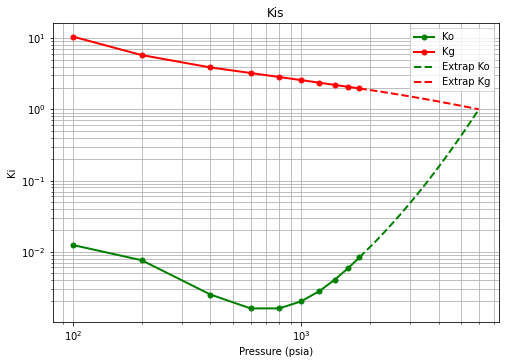

In [33]:
# Function to return y value for given x, between two pairs of defined points
# While honoring slope seen at first pair of points
# y = a*x**2 + b*x + c
# dy/dx = Slope = 2*a*x + b
def quad_extrap(slope,x1,y1,x2,y2,x):
    b = (slope*(x2**2-x1**2)+2*x1*(y1-y2))/(x1-x2)**2
    a = (slope - b)/(2*x1)
    c = y1 - a*x1**2 - b*x1
    return a*x**2 +b*x + c

def nextplot(i,j,nx):
    if j < nx-1:                                                                                                                       
        j+=1                                                                                                                                                                                                                                                 
    else:                                                                                                                              
        j = 0                                                                                                                          
        i += 1
    return [i,j]

# Calculate slopes (in log-log space) of dko/dp and dkg/dp
x1 = (PVT['P'].iloc[last_row])
x2 = (Pk)
kO_slope = log10(PVT['ko'].iloc[last_row] / PVT['ko'].iloc[last_row-1])/log10(x1 / PVT['P'].iloc[last_row-1])
kG_slope = log10(PVT['kg'].iloc[last_row] / PVT['kg'].iloc[last_row-1])/log10(x1 / PVT['P'].iloc[last_row-1])

ko_ext, kg_ext, p_ext = [[] for i in range(3)]
deltap = (Pk - x1 - 1)/(n_ext-1)

for i in range(n_ext):        
    p_ext.append(round(x1 + i*deltap,0))
    ko_ext.append(10**(quad_extrap(kO_slope,log10(x1),log10(PVT['ko'].iloc[last_row]),log10(x2),0,log10(p_ext[-1]))))
    kg_ext.append(10**(quad_extrap(kG_slope,log10(x1),log10(PVT['kg'].iloc[last_row]),log10(x2),0,log10(p_ext[-1]))))

p_tc = PVT['P'].tolist()
bg = PVT['Bg'].tolist()
bo = PVT['Bo'].tolist()
Rv = PVT['Rv'].tolist()
Rs = PVT['Rs'].tolist()

dBgdPo = [(bg[i]-bg[i-1])/(p_tc[i]-p_tc[i-1]) for i in range(1,len(p_tc))]
dBodPo = [(bo[i]-bo[i-1])/(p_tc[i]-p_tc[i-1]) for i in range(1,len(p_tc))]
dRsdPo = [(Rs[i]-Rs[i-1])/(p_tc[i]-p_tc[i-1]) for i in range(1,len(p_tc))]
dRvdPo = [(Rv[i]-Rv[i-1])/(p_tc[i]-p_tc[i-1]) for i in range(1,len(p_tc))]
TcOil = [1/bo[i+1]*(-dBodPo[i]+dRsdPo[i]*(bg[i+1]-Rv[i+1]*bo[i+1])/(1-Rs[i+1]*Rv[i+1])) for i in range(len(p_tc)-1)]
TcGas = [1/bg[i+1]*(-dBgdPo[i]+dRvdPo[i]*(bo[i+1]-Rs[i+1]*bg[i+1])/(1-Rs[i+1]*Rv[i+1])) for i in range(len(p_tc)-1)]
p_tc.pop(0) # Remove first pressure point so list lengths match

nx, ny = [1,1]
dxs, dys = [8.0, 5.5]                                                                                                                               
i = j = 0
      
fig, ax = plt.subplots(ny, nx, sharey = False, figsize=(dxs*nx, dys*ny), squeeze=False ) # squeeze = False ensures 2 x 1 does not get converted to 1D
ax[i,j].title.set_text('Kis')
ax[i,j].plot(PVT['P'], PVT['ko'], label='Ko', color='green', linewidth=2,marker='o',markersize=5)   
ax[i,j].plot(PVT['P'], PVT['kg'], label='Kg', color='red', linewidth=2,marker='o',markersize=5) 
ax[i,j].plot(p_ext, ko_ext, label='Extrap Ko', color='green', linewidth=2,markersize=5,linestyle = '--')   
ax[i,j].plot(p_ext, kg_ext, label='Extrap Kg', color='red', linewidth=2,markersize=5,linestyle = '--')  
ax[i,j].grid(True, which = "both") 
ax[i,j].set_yscale('log')
ax[i,j].set_xscale('log')   
ax[i,j].set_xlabel('Pressure (psia)')                                                                                        
ax[i,j].set_ylabel('Ki')                                                                                                    
ax[i,j].legend() 

plt.show()


In [7]:
# Return cubic Z roots of PR EOS using Numpy Python root finder numpy.roots
def zroots(a, b, p, t):    
    global R
    A = a * p / (R*t) ** 2 # Eq 4.9
    B = b * p / (R*t)
    p1 = B - 1
    p2 = A - 3 * B ** 2 - 2 * B
    p3 = -(A * B - B ** 2 - B ** 3)   # Eq 4.19
    roots = np.roots([1,p1,p2,p3]) 
    Zroot = []
    for item in roots:
        if np.iscomplex(item): # Remove complex roots
            item = None
            continue
        else:
            item = item.real   # Catch solutions with +0i and convert to real
            Zroot.append(item)
    
    # If 3 real roots returned, eliminate the middle one
    if len(Zroot) == 3:
            Zroot.sort()
            Zroot.pop(1)     
    return(Zroot)

def veos_calc(v, xo, so, bo, xg, sg, bg):
    return v + xo*so*bo + xg*sg*bg

def a_calc(ao, xo, ag, xg):
    return ao*xo**2+ag*xg**2+2*(ao*ag)**0.5*xo*xg

def b_calc(bo, xo, bg, xg):
    return bo*xo+bg*xg

#First guess for ao and bo for oil
def ab_o(ST_MWO, ST_DENO, Tres): #Tres in Deg Rankine
    sgo = ST_DENO/62.4
    Tc = 608 + 364*log10(ST_MWO-71.2)+(2450*log10(ST_MWO)-3800)*log10(sgo) # Eq 32
    Pc = 1188 - 431*log10(ST_MWO-61.1)+(2319-852*log10(ST_MWO-53.7))*(sgo-0.8)
    w = 0.000003*ST_MWO**2+0.004*ST_MWO-0.039
    if w <= 0.49:
        m = 0.37464+1.54226*w-0.26992*w**2
    else:
        m = 0.3796+1.485*w-0.1644*w**2+0.01667*w**3
    Alpha = (1+m*(1-(Tres/Tc)**0.5))**2
    R = 10.73146 # Universal gas constant, psia-ft3/R-lbm mol
    a = 0.45724*R**2*Tc**2*Alpha/Pc
    b = 0.07780*R*Tc/Pc
    return [a, b, Tc, Pc]

#First guess for ao and bo for gas    
def ab_g(ST_MWG, ST_DENG, Tres): #Tres in Deg Rankine
    sg = ST_MWG/28.966
    if sg < 0.75:
        Tc = 168 + 325*sg-12.5*sg**2
        Pc = 667+15*sg-37.5*sg**2
    else:
        Tc = 187 + 330*sg-71.5*sg**2
        Pc = 706+51.7*sg-11.1*sg**2
    w = 0.1637*sg-0.0792
    if w <= 0.49:
        m = 0.37464+1.54226*w-0.26992*w**2
    else:
        m = 0.3796+1.485*w-0.1644*w**2+0.01667*w**3
    Alpha = (1+m*(1-(Tres/Tc)**0.5))**2
    R = 10.73146 # Universal gas constant, psia-ft3/R-lbm mol
    a = 0.45724*R**2*Tc**2*Alpha/Pc
    b = 0.07780*R*Tc/Pc
    return [a, b, Tc, Pc]

def P_EOS(x):
    R = 10.73146 # Universal gas constant, psia-ft3/R-lbm mol
    vo, vg, so, sg, xo, xg, ao, bo, ag, bg, T, yo, yg  = x # Observed parameters
    veos = veos_calc(vo, xo, so, bo, xg, sg, bg)
    a = a_calc(ao, xo, ag, xg)
    b = b_calc(bo, xo, bg, xg)
    part2 = R*T/(veos-b)
    part3 = a/(veos*(veos+b)+b*(veos-b))
    p_o = part2-part3
    
    veos = veos_calc(vg, yo, so, bo, yg, sg, bg)
    a = a_calc(ao, yo, ag, yg)
    b = b_calc(bo, yo, bg, yg)
    part2 = R*T/(veos-b)
    part3 = a/(veos*(veos+b)+b*(veos-b))
    p_g = part2-part3
    return [p_o, p_g]

def Molar_vol_from_ZRoot(p, zo, zg, ao, bo, ag, bg, T, so, sg ):
    R = 10.73146 # Universal gas constant, psia-ft3/R-lbm mol
    a = a_calc(ao, zo, ag, zg)
    b = b_calc(bo, zo, bg, zg)
    Z = max(zroots(a, b, p, T))
    veos = Z * R * T / p
    v = veos - (zo * so * bo + zg * sg * bg)
    return v

def sum_Global_Z_errors(x,rows):
    err_tot = 0
    ao, bo, so, ag, bg, sg, T = x
    for row in rows:
        p, vo, vg, xo, xg, yo, yg = row
        err_tot += abs(Molar_vol_from_ZRoot(p, xo, xg, ao, bo, ag, bg, T, so, sg )-vo)
        err_tot += abs(Molar_vol_from_ZRoot(p, yo, yg, ao, bo, ag, bg, T, so, sg )-vg)
    return err_tot

def sum_Local_Z_errors(x,row):
    err_tot = 0
    so, sg = x
    p, vo, vg, xo, xg, ao, bo, ag, bg, T, yo, yg = row
    err_tot += abs(Molar_vol_from_ZRoot(p, xo, xg, ao, bo, ag, bg, T, so, sg )-vo)
    err_tot += abs(Molar_vol_from_ZRoot(p, yo, yg, ao, bo, ag, bg, T, so, sg )-vg)
    return err_tot

## Regress on EOS system wide a, b, s variables for surface liquid and surface gass

Optimization terminated successfully.
         Current function value: 0.276557
         Iterations: 318
         Function evaluations: 503
    ao       bo           so       ag       bg            sg     Tres
------  -------  -----------  -------  -------  ------------  -------
287449  2.58563  0.000224244  9965.82  0.55297  -0.000121872  581.413


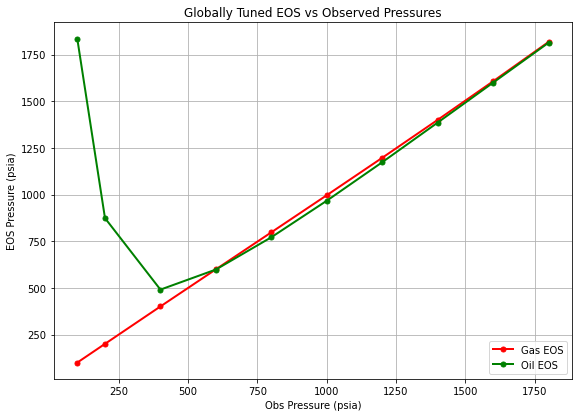

In [8]:
# Initial guesses
Tres = 220+460 # Deg R (Assume we don't know for sure the reservoir temperature)
ao, bo, Tco, Pco = ab_o(ST_MWO, ST_DENO, Tres)
ag, bg, Tcg, Pcg = ab_g(ST_MWG, ST_DENG, Tres)
so = sg = 0
ys =[]
for index, row in PVT.iterrows():
    ys.append([row['P'],row['vo'],row['vg'],row['xo'],row['xgi'],row['yo'],row['ygi']])

#Solve
res = minimize(sum_Global_Z_errors, [ao, bo, so, ag, bg, sg, Tres], method='nelder-mead',args=(ys), options={'xatol': 350, 'disp': True})
ao, bo, so, ag, bg, sg, Tres =  res['x']
p_eoso = []
p_eosg = []
for i, y in enumerate(ys):
    p, vo, vg, xo, xg, yo, yg = y
    x = vo, vg, so, sg, xo, xg, ao, bo, ag, bg, Tres, yo, yg
    p_o, p_g = P_EOS(x)
    p_eoso.append(p_o)
    p_eosg.append(p_g)
    
nx, ny = [1,1]
dxs, dys = [8.0, 5.5]                                                                                                                               
i = j = 0                     
fig, ax = plt.subplots(ny, nx, sharey = False, figsize=(dxs*nx, dys*ny), squeeze=False ) # squeeze = False ensures 2 x 1 does not get converted to 1D                                                                                
fig.subplots_adjust(top=0.95, bottom = 0.05, left = 0.05, right = 0.95)   
ax[i,j].title.set_text('Globally Tuned EOS vs Observed Pressures')
ax[i,j].plot(PVT['P'], p_eosg, label='Gas EOS', color='red', linewidth=2,marker='o',markersize=5)  
ax[i,j].plot(PVT['P'], p_eoso, label='Oil EOS', color='green', linewidth=2,marker='o',markersize=5)  
ax[i,j].grid(True, which="both") 
#ax[i,j].set_yscale('log')
#ax[i,j].set_xscale('log')                                                                                                               
ax[i,j].set_xlabel('Obs Pressure (psia)')                                                                                        
ax[i,j].set_ylabel('EOS Pressure (psia)')                                                                                                    
ax[i,j].legend()  

plt.plot()   

table=[]
header=['ao','bo', 'so', 'ag', 'bg', 'sg', 'Tres'] 
table.append([ao, bo, so, ag, bg, sg, Tres])
print(tabulate(table,headers=header))
EOS_ab_dic = {}
EOS_ab_dic['ao'] = ao
EOS_ab_dic['bo'] = bo
EOS_ab_dic['ag'] = ag
EOS_ab_dic['bg'] = bg
EOS_ab_dic['T'] = Tres

## Calculate exact volume corrections at each input data step to match pressure exactly

   P            so            sg
----  ------------  ------------
 100   0.0206964    -0.00121787
 200   0.0054218     0.113928
 400  -0.00218518    0.0563329
 600   0.00145988   -0.0134414
 800   0.00391959   -0.0380987
1000   0.00450599   -0.0380609
1200   0.0029998    -0.0227666
1400  -0.000250429   0.000117617
1600  -0.00492741    0.0258283
1800  -0.0105633     0.0509896


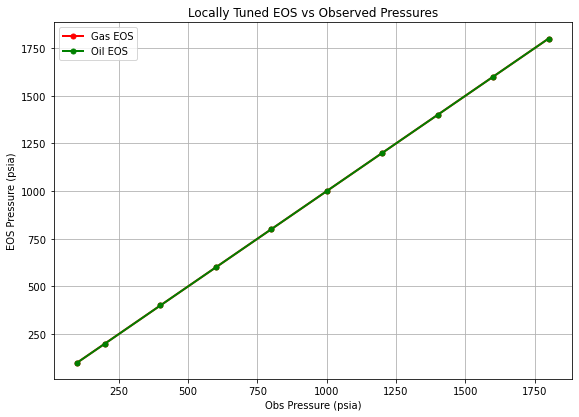

In [9]:
# Now calculate exact volume correction at each input data step for vapor and liquid
so_tab = []
sg_tab = []
table=[]
ao, bo, ag, bg, T = EOS_ab_dic['ao'], EOS_ab_dic['bo'], EOS_ab_dic['ag'], EOS_ab_dic['bg'], EOS_ab_dic['T']
for y in ys:
    p,vo,vg,xo,xg,yo,yg = y
    args = [p, vo, vg, xo, xg, ao, bo, ag, bg, T, yo, yg] # Observed parameters
    bnds = ((-0.2, 0.2),(-0.2, 0.2)) # Limit search ranges to prevent non-physical results
    res = minimize(sum_Local_Z_errors, [so, sg], method='SLSQP',args=(args), bounds=bnds, tol = 1e-6, options={'disp': False, 'maxiter':100})    
                   
    so_fit, sg_fit =  res['x']
    table.append([p, so_fit, sg_fit])
    so_tab.append(so_fit)
    sg_tab.append(sg_fit)

p_eoso = []
p_eosg = []
for i, y in enumerate(ys):
    p,vo,vg,xo,xg,yo,yg = y
    x = vo, vg, so_tab[i], sg_tab[i], xo, xg, ao, bo, ag, bg, T, yo, yg
    p_o, p_g = P_EOS(x)
    p_eoso.append(p_o)
    p_eosg.append(p_g)

PVT['so'] = so_tab
PVT['sg'] = sg_tab

nx, ny = [1,1]
dxs, dys = [8.0, 5.5]                                                                                                                               
i = j = 0                     
fig, ax = plt.subplots(ny, nx, sharey = False, figsize=(dxs*nx, dys*ny), squeeze=False ) # squeeze = False ensures 2 x 1 does not get converted to 1D                                                                                
fig.subplots_adjust(top=0.95, bottom = 0.05, left = 0.05, right = 0.95)   
ax[i,j].title.set_text('Locally Tuned EOS vs Observed Pressures')
ax[i,j].plot(PVT['P'], p_eosg, label='Gas EOS', color='red', linewidth=2,marker='o',markersize=5)  
ax[i,j].plot(PVT['P'], p_eoso, label='Oil EOS', color='green', linewidth=2,marker='o',markersize=5)  
ax[i,j].grid(True, which="both") 
#ax[i,j].set_yscale('log')
#ax[i,j].set_xscale('log')                                                                                                               
ax[i,j].set_xlabel('Obs Pressure (psia)')                                                                                        
ax[i,j].set_ylabel('EOS Pressure (psia)')                                                                                                    
ax[i,j].legend()  

plt.plot()    

header=['P','so', 'sg'] 
print(tabulate(table,headers=header))

## Regress on global LBC Viscosity coefficients

  den_co    den_cg    squiggle_to    squiggle_tg         uoo        ugg
--------  --------  -------------  -------------  ----------  ---------
 15.0139   12.9529      0.0309189      0.0455383  0.00396265  0.0113001


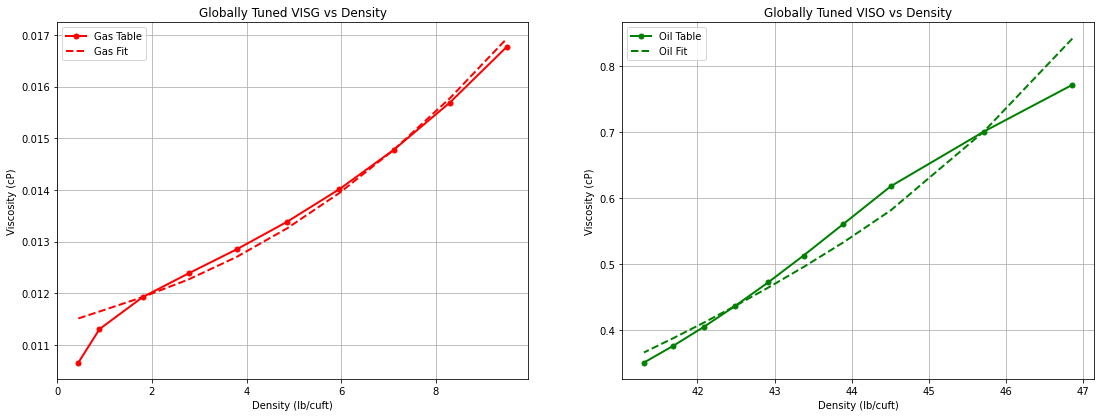

In [10]:
def LBC_Vis(uo, squiggle_t, den_r, LBCA):
    rhs = LBCA[0]+LBCA[1]*den_r+LBCA[2]*den_r**2+LBCA[3]*den_r**3+LBCA[4]*den_r**4
    rhs = rhs**4
    rhs = rhs - 1e-04
    rhs = rhs / squiggle_t
    u = rhs + uo
    return u

def regress_LBC(x, args):
    den_co, den_cg, squiggle_to, squiggle_tg, uoo, uog = x
    LBCA, xo_data, xg_data, yo_data, yg_data, viso_data, visg_data, deno_data, deng_data = args
    err = 0
    for i in range(len(xo_data)):
        
        # Oil Viscosity
        rho_pc = den_co*xo_data[i]+den_cg*xg_data[i]
        squiggle_t = squiggle_to*xo_data[i] + squiggle_tg*xg_data[i]
        uo = uoo*xo_data[i] + uog*xg_data[i]
        err += abs(LBC_Vis(uo, squiggle_t, deno_data[i]/rho_pc, LBCA)-viso_data[i])/viso_data[i]
        
        # Gas Viscosity
        rho_pc = den_co*yo_data[i]+den_cg*yg_data[i]
        squiggle_t = squiggle_to*yo_data[i] + squiggle_tg*yg_data[i]
        uo = uoo*yo_data[i] + uog*yg_data[i]
        err += abs(LBC_Vis(uo, squiggle_t, deng_data[i]/rho_pc, LBCA)-visg_data[i])/visg_data[i]
    return err

def regress_LBC_denc(x, args):
    den_co, den_cg = x
    LBCA, xo_data, xg_data, yo_data, yg_data, viso_data, visg_data, deno_data, deng_data, squiggle_to, squiggle_tg, uoo, uog = args
    err = 0
        
    # Oil Viscosity
    rho_pc = den_co*xo_data+den_cg*xg_data
    squiggle_t = squiggle_to*xo_data + squiggle_tg*xg_data
    uo = uoo*xo_data + uog*xg_data
    err += abs(LBC_Vis(uo, squiggle_t, deno_data/rho_pc, LBCA)-viso_data)/viso_data
        
    # Gas Viscosity
    rho_pc = den_co*yo_data+den_cg*yg_data
    squiggle_t = squiggle_to*yo_data + squiggle_tg*yg_data
    uo = uoo*yo_data + uog*yg_data
    err += abs(LBC_Vis(uo, squiggle_t, deng_data/rho_pc, LBCA)-visg_data)/visg_data
    return err


# Default Lohrenz-Bray-Clark Correlation coefficients
LBCA = [0.10230, 0.023364, 0.058533, -0.040758, 0.0093324]

# Starting values for regression
sgo = ST_DENO / 62.4
vco = 21.573+0.015122*ST_MWO-27.656*sgo+0.070615*ST_MWO*sgo
den_co = ST_MWO / vco
Zc = 0.3074 # Defined in Eq 4.20 of Monograph
vcg = Zc*R*Tcg/Pcg
den_cg = ST_MWG / vcg
Tro = Tres / Tco
squiggle_to = 5.35*(Tco/ST_MWO**3/Pco**4)**(1/6) # Note Eqn in paper incorrect
if Tro <= 1.5:
    uoo = 34e-5*Tro**0.94/squiggle_to # Note Eqn in paper incorrect
else:
    uoo = 17.78e-5*(4.58*Tro-1.67)**(5/8)/squiggle_to # Note Eqn in paper incorrect
squiggle_tg = 5.35*(Tcg/ST_MWG**3/Pcg**4)**(1/6) # Note Eqn in paper incorrect
Trg = Tres / Tcg
if Trg <= 1.5:
    uog = 34e-5*Trg**0.94/squiggle_tg # Note Eqn in paper incorrect
else:
    uog = 17.78e-5*(4.58*Trg-1.67)**(5/8)/squiggle_tg # Note Eqn in paper incorrect
    
# Create list of data points to match against
xo_data = PVT['xo'].tolist()
xg_data = PVT['xgi'].tolist()
yo_data = PVT['yo'].tolist()
yg_data = PVT['ygi'].tolist()
viso_data = PVT['uo'].tolist()
visg_data = PVT['ug'].tolist()
deno_data = PVT['DENO'].tolist()
deng_data = PVT['DENG'].tolist()

args = [LBCA, xo_data, xg_data, yo_data, yg_data, viso_data, visg_data, deno_data, deng_data] # Fixed / Target values

x = [den_co, den_cg, squiggle_to, squiggle_tg, uoo, uog] # Starting guesses of parameters to regress
res = minimize(regress_LBC, x, method='nelder-mead',args=(args), tol = 1e-6, options={'disp': False, 'maxiter':10000})
den_co, den_cg, squiggle_to, squiggle_tg, uoo, uog =  res['x']

rho_pco = [den_co*xo_data[i]+den_cg*xg_data[i] for i in range(len(xg_data))]
squiggle_too = [squiggle_to*xo_data[i] + squiggle_tg*xg_data[i] for i in range(len(xg_data))]
uoo_o = [uoo*xo_data[i] + uog*xg_data[i] for i in range(len(xg_data))]
denro = [deno_data[i]/rho_pco[i] for i in range(len(xg_data))]

rho_pcg = [den_co*yo_data[i]+den_cg*yg_data[i] for i in range(len(yg_data))]
squiggle_tgo = [squiggle_to*yo_data[i] + squiggle_tg*yg_data[i] for i in range(len(yg_data))]
uog_o = [uoo*yo_data[i] + uog*yg_data[i] for i in range(len(yg_data))]
denrg = [deng_data[i]/rho_pcg[i] for i in range(len(yg_data))]

fit_visg = [LBC_Vis(uog_o[i], squiggle_tgo[i], x, LBCA) for i, x in enumerate(denrg)]
fit_viso = [LBC_Vis(uoo_o[i], squiggle_too[i], x, LBCA) for i, x in enumerate(denro)]

header=['den_co', 'den_cg', 'squiggle_to', 'squiggle_tg', 'uoo', 'ugg'] 
table = [[den_co, den_cg,squiggle_to, squiggle_tg, uoo,uog]]
print(tabulate(table,headers=header))

nx, ny = [2,1]
dxs, dys = [8.0, 5.5]
i = j = 0                  
fig, ax = plt.subplots(ny, nx, sharey = False, figsize=(dxs*nx, dys*ny), squeeze=False ) # squeeze = False ensures 2 x 1 does not get converted to 1D                                                                                
fig.subplots_adjust(top=0.95, bottom = 0.05, left = 0.05, right = 0.95)   

ax[i,j].title.set_text('Globally Tuned VISG vs Density')
ax[i,j].plot(PVT['DENG'], PVT['ug'], label='Gas Table', color='red', linewidth=2,marker='o',markersize=5)  
ax[i,j].plot(PVT['DENG'], fit_visg, label='Gas Fit', color='red', linewidth=2,linestyle = '--')   
ax[i,j].grid(True, which="both")                                                                                                               
ax[i,j].set_xlabel('Density (lb/cuft)')                                                                                         
ax[i,j].set_ylabel('Viscosity (cP)')                                                                                                    
ax[i,j].legend() 

i, j = nextplot(i,j,nx)
ax[i,j].title.set_text('Globally Tuned VISO vs Density')
ax[i,j].plot(PVT['DENO'], PVT['uo'], label='Oil Table', color='green', linewidth=2,marker='o',markersize=5) 
ax[i,j].plot(PVT['DENO'], fit_viso, label='Oil Fit', color='green', linewidth=2,linestyle = '--') 
ax[i,j].grid(True, which="both")                                                                                                               
ax[i,j].set_xlabel('Density (lb/cuft)')                                                                                        
ax[i,j].set_ylabel('Viscosity (cP)')                                                                                                    
ax[i,j].legend() 

plt.show()



## Regress of Rho_co and Rho_cg for each of the tabled viscosities to match viscosity exactly

   P    den_co    den_cg
----  --------  --------
 100   15.0115   14.2482
 200   14.7454   14.2482
 400   14.8978   12.9531
 600   15.4634   11.7071
 800   15.4529   11.9966
1000   15.3273   12.3937
1200   15.1827   12.7211
1400   15.058    12.9528
1600   14.968    13.0993
1800   14.9259   13.1705


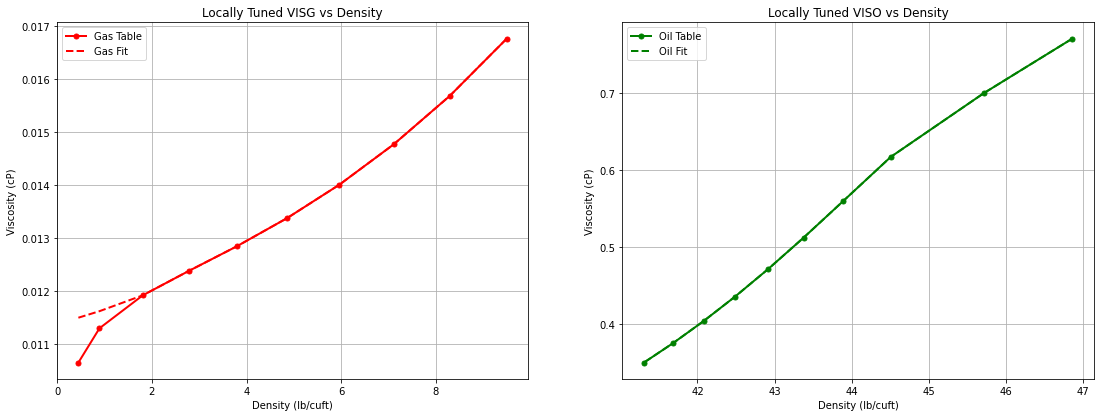

In [11]:
den_co_fit, den_cg_fit = [[] for i in range(2)]
for i in range(len(xo_data)):
    x = [den_co, den_cg] # Starting guesses of parameters to regress
    args = [LBCA, xo_data[i], xg_data[i], yo_data[i], yg_data[i], viso_data[i], visg_data[i], deno_data[i], deng_data[i], squiggle_to, squiggle_tg, uoo, uog] # Fixed / Target values
    bnds = ((0.9*den_co, 1.1*den_co),(0.9*den_cg, 1.1*den_cg)) # Limit search ranges to prevent non-physical results
    res = minimize(regress_LBC_denc, x, method='SLSQP',args=(args), bounds=bnds, tol = 1e-8, options={'disp': False, 'maxiter':10000})
    a, b =  res['x']
    den_co_fit.append(a)
    den_cg_fit.append(b)

PVT['den_co'] = den_co_fit
PVT['den_cg'] = den_cg_fit
ps = PVT['P'].tolist()

header=['P','den_co', 'den_cg'] 
table = [[ps[i],den_co_fit[i], den_cg_fit[i] ] for i, val in enumerate(den_co_fit)]
print(tabulate(table,headers=header))

rho_pco = [den_co_fit[i]*xo_data[i]+den_cg_fit[i]*xg_data[i] for i in range(len(xg_data))]
squiggle_too = [squiggle_to*xo_data[i] + squiggle_tg*xg_data[i] for i in range(len(xg_data))]
uoo_o = [uoo*xo_data[i] + uog*xg_data[i] for i in range(len(xg_data))]
denro = [deno_data[i]/rho_pco[i] for i in range(len(xg_data))]

rho_pcg = [den_co_fit[i]*yo_data[i]+den_cg_fit[i]*yg_data[i] for i in range(len(yg_data))]
squiggle_tgo = [squiggle_to*yo_data[i] + squiggle_tg*yg_data[i] for i in range(len(yg_data))]
uog_o = [uoo*yo_data[i] + uog*yg_data[i] for i in range(len(yg_data))]
denrg = [deng_data[i]/rho_pcg[i] for i in range(len(yg_data))]

fit_visg = [LBC_Vis(uog_o[i], squiggle_tgo[i], x, LBCA) for i, x in enumerate(denrg)]
fit_viso = [LBC_Vis(uoo_o[i], squiggle_too[i], x, LBCA) for i, x in enumerate(denro)]

nx, ny = [2,1]
dxs, dys = [8.0, 5.5]
i = j = 0                  
fig, ax = plt.subplots(ny, nx, sharey = False, figsize=(dxs*nx, dys*ny), squeeze=False ) # squeeze = False ensures 2 x 1 does not get converted to 1D                                                                                
fig.subplots_adjust(top=0.95, bottom = 0.05, left = 0.05, right = 0.95)   

ax[i,j].title.set_text('Locally Tuned VISG vs Density')
ax[i,j].plot(PVT['DENG'], PVT['ug'], label='Gas Table', color='red', linewidth=2,marker='o',markersize=5)  
ax[i,j].plot(PVT['DENG'], fit_visg, label='Gas Fit', color='red', linewidth=2,linestyle = '--')   
ax[i,j].grid(True, which="both")                                                                                                                
ax[i,j].set_xlabel('Density (lb/cuft)')                                                                                         
ax[i,j].set_ylabel('Viscosity (cP)')                                                                                                    
ax[i,j].legend() 

i, j = nextplot(i,j,nx)
ax[i,j].title.set_text('Locally Tuned VISO vs Density')
ax[i,j].plot(PVT['DENO'], PVT['uo'], label='Oil Table', color='green', linewidth=2,marker='o',markersize=5) 
ax[i,j].plot(PVT['DENO'], fit_viso, label='Oil Fit', color='green', linewidth=2,linestyle = '--') 
ax[i,j].grid(True, which="both")                                                                                                               
ax[i,j].set_xlabel('Density (lb/cuft)')                                                                                        
ax[i,j].set_ylabel('Viscosity (cP)')                                                                                                    
ax[i,j].legend() 

plt.show()


## Extend saturated tables to convergence pressure

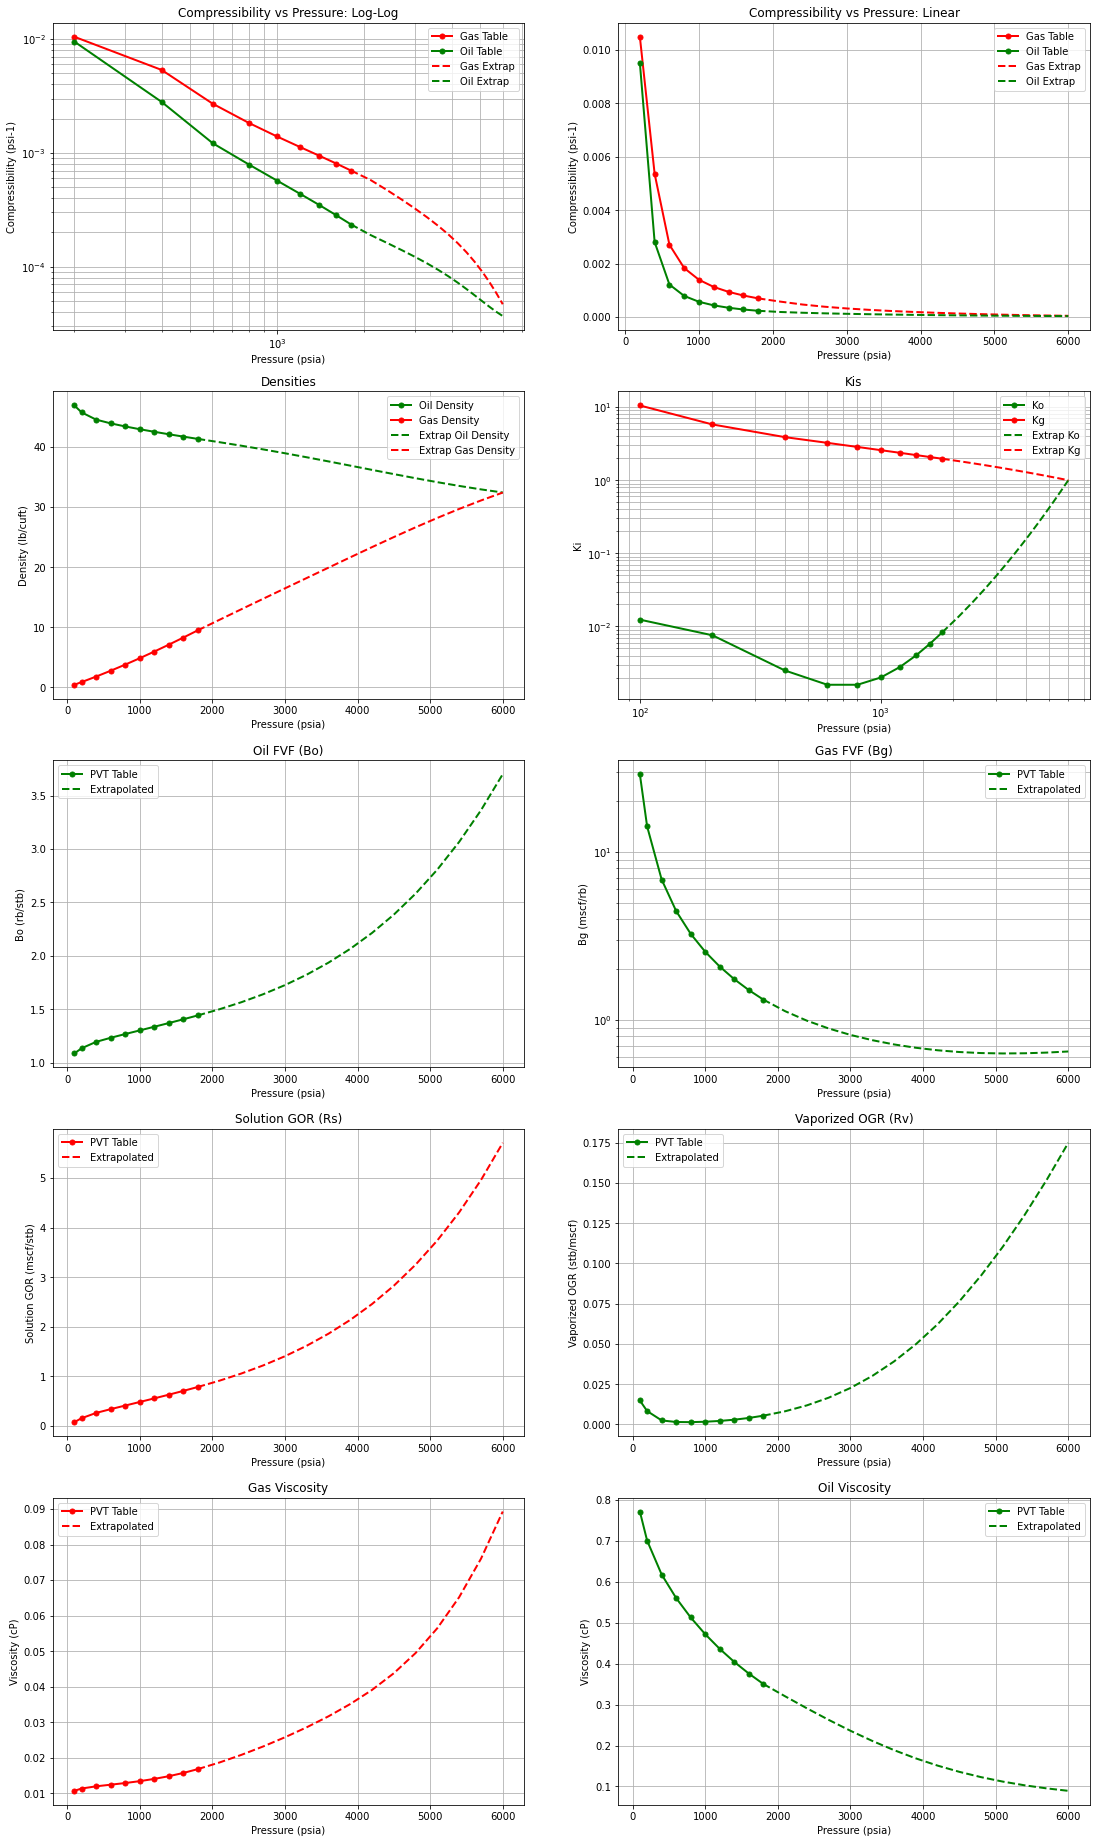

In [12]:
Rs_ext, rs_ext, xo_ext, yo_ext,xg_ext, yg_ext, MWo_ext, MWg_ext, DENO_ext, DENG_ext, vo_ext, vg_ext, Bo_ext, Bg_ext, uo_ext, ug_ext = [[] for i in range(16)]
ao, bo, ag, bg, T = EOS_ab_dic['ao'], EOS_ab_dic['bo'], EOS_ab_dic['ag'], EOS_ab_dic['bg'], EOS_ab_dic['T']

# Setup linear interpolation functions for volume and density corrections
psats = PVT['P'].tolist()
so_interp = interpolate.interp1d(psats, so_tab)
sg_interp = interpolate.interp1d(psats, sg_tab)
den_co_interp = interpolate.interp1d(psats, den_co_fit)
den_cg_interp = interpolate.interp1d(psats, den_cg_fit)

for i, p in enumerate(p_ext):
    ko = ko_ext[i]
    kg = kg_ext[i]
    Rs_ext.append((Co*(1-ko)/(kg-1)/Mult))
    rs_ext.append(ko*(kg-1)/(Co*kg*(1-ko))*Mult)
    xo_ext.append(Co/(Rs_ext[i]*Mult+Co))
    xg_ext.append(1 - xo_ext[i])
    yo_ext.append(Lo*rs_ext[i]/(Lg+Lo*rs_ext[i]))
    yg_ext.append(1-yo_ext[i])
    MWo_ext.append(ST_MWO * xo_ext[-1] + ST_MWG*xg_ext[-1])
    MWg_ext.append(ST_MWO * yo_ext[-1] + ST_MWG*yg_ext[-1])
    max_psat = PVT['P'].iloc[last_row]

for i, psat in enumerate(p_ext):
    interp_p = psat
    p = psat
    if max_psat <= psat:
        interp_p = max_psat
    
    so  = so_interp(interp_p)
    sg  = sg_interp(interp_p)
    
    # Oil
    # Solve cubic roots for molar volume
    vop = Molar_vol_from_ZRoot(p, xo_ext[i], xg_ext[i], ao, bo, ag, bg, T, so, sg )
    MWo = MWo_ext[i]
    rho_o = MWo / vop
    MWo_ext.append(MWo)
    DENO_ext.append(rho_o)
    Bo_ext.append((ST_DENO + ST_DENG * Rs_ext[i] * Mult) / rho_o)
    
    # Use LBC correlation to estimate viscosity
    rho_cg = den_cg_interp(interp_p)
    rho_co = den_co_interp(interp_p)
    rho_pco = rho_co*xo_ext[i]+rho_cg*xg_ext[i]
    rho_pro = rho_o / rho_pco
    squiggle_t = squiggle_to*xo_ext[i]+squiggle_tg*xg_ext[i]
    uo = uoo*xo_ext[i] + uog*xg_ext[i]
    uoil = LBC_Vis(uo, squiggle_t, rho_pro, LBCA)
    uo_ext.append(uoil)
    
    # Gas
    # Solve cubic roots for molar volume
    vgp = Molar_vol_from_ZRoot(p, yo_ext[i], yg_ext[i], ao, bo, ag, bg, T, so, sg )
    MWg = ST_MWO*yo_ext[i] + ST_MWG*yg_ext[i]
    rho_g = MWg / vgp
    MWg_ext.append(MWg)
    DENG_ext.append(rho_g)
    Bg_ext.append((ST_DENG + ST_DENO * rs_ext[i] / Mult) / rho_g * Mult)
    
    # Use LBC correlation to estimate viscosity
    rho_co = den_co_interp(interp_p)
    rho_cg = den_cg_interp(interp_p)
    rho_pcg = rho_co*yo_ext[i]+rho_cg*yg_ext[i]
    rho_prg = rho_g / rho_pcg
    squiggle_t = squiggle_to*yo_ext[i]+squiggle_tg*yg_ext[i]
    uo = uoo*yo_ext[i] + uog*yg_ext[i]
    ugas = LBC_Vis(uo, squiggle_t, rho_prg, LBCA)
    ug_ext.append(ugas)

# Calculate compressibilities
dBgdPo = [(Bg_ext[i]-Bg_ext[i-1])/(p_ext[i]-p_ext[i-1]) for i in range(1,len(p_ext))]
dBodPo = [(Bo_ext[i]-Bo_ext[i-1])/(p_ext[i]-p_ext[i-1]) for i in range(1,len(p_ext))]
dRsdPo = [(Rs_ext[i]-Rs_ext[i-1])/(p_ext[i]-p_ext[i-1]) for i in range(1,len(p_ext))]
dRvdPo = [(rs_ext[i]-rs_ext[i-1])/(p_ext[i]-p_ext[i-1]) for i in range(1,len(p_ext))]
TcOil_ext = [1/Bo_ext[i+1]*(-dBodPo[i]+dRsdPo[i]*(Bg_ext[i+1]-rs_ext[i+1]*Bo_ext[i+1])/(1-Rs_ext[i+1]*rs_ext[i+1])) for i in range(len(p_ext)-1)]
TcGas_ext = [1/Bg_ext[i+1]*(-dBgdPo[i]+dRvdPo[i]*(Bo_ext[i+1]-Rs_ext[i+1]*Bg_ext[i+1])/(1-Rs_ext[i+1]*rs_ext[i+1])) for i in range(len(p_ext)-1)]
p_ext_temp = p_ext.copy()
p_ext_temp.pop(0)

TcOil_ext.insert(0,TcOil[-1])
TcGas_ext.insert(0,TcGas[-1])
p_ext_temp.insert(0,p_tc[-1])

nx, ny = [2,5]
dxs, dys = [8.0, 5.5]                                                                                                                               
i = j = 0
fig, ax = plt.subplots(ny, nx, sharey = False, figsize=(dxs*nx, dys*ny), squeeze=False ) # squeeze = False ensures 2 x 1 does not get converted to 1D                                                                                
fig.subplots_adjust(top=0.95, bottom = 0.05, left = 0.05, right = 0.95)   
ax[i,j].title.set_text('Compressibility vs Pressure: Log-Log')
ax[i,j].plot(p_tc, TcGas, label='Gas Table', color='red', linewidth=2,marker='o',markersize=5)  
ax[i,j].plot(p_tc, TcOil, label='Oil Table', color='green', linewidth=2,marker='o',markersize=5)   
ax[i,j].plot(p_ext_temp, TcGas_ext, label='Gas Extrap', color='red', linewidth=2,linestyle = '--')  
ax[i,j].plot(p_ext_temp, TcOil_ext, label='Oil Extrap', color='green', linewidth=2,linestyle = '--') 
ax[i,j].grid(True, which="both") 
ax[i,j].set_yscale('log')
ax[i,j].set_xscale('log')                                                                                                               
ax[i,j].set_xlabel('Pressure (psia)')                                                                                        
ax[i,j].set_ylabel('Compressibility (psi-1)')                                                                                                    
ax[i,j].legend() 

i, j = nextplot(i,j,nx)
ax[i,j].title.set_text('Compressibility vs Pressure: Linear')
ax[i,j].plot(p_tc, TcGas, label='Gas Table', color='red', linewidth=2,marker='o',markersize=5)  
ax[i,j].plot(p_tc, TcOil, label='Oil Table', color='green', linewidth=2,marker='o',markersize=5)   
ax[i,j].plot(p_ext_temp, TcGas_ext, label='Gas Extrap', color='red', linewidth=2,linestyle = '--')  
ax[i,j].plot(p_ext_temp, TcOil_ext, label='Oil Extrap', color='green', linewidth=2,linestyle = '--') 
ax[i,j].grid(True, which="both")                                                                                                               
ax[i,j].set_xlabel('Pressure (psia)')                                                                                        
ax[i,j].set_ylabel('Compressibility (psi-1)')                                                                                                    
ax[i,j].legend() 
    
i, j = nextplot(i,j,nx)
ax[i,j].title.set_text('Densities')
ax[i,j].plot(PVT['P'], PVT['DENO'], label='Oil Density', color='green', linewidth=2,marker='o',markersize=5)  
ax[i,j].plot(PVT['P'], PVT['DENG'], label='Gas Density', color='red', linewidth=2,marker='o',markersize=5)       
ax[i,j].plot(p_ext, DENO_ext, label='Extrap Oil Density', color='green', linewidth=2,markersize=5,linestyle = '--')  
ax[i,j].plot(p_ext, DENG_ext, label='Extrap Gas Density', color='red', linewidth=2,markersize=5,linestyle = '--')   
ax[i,j].grid(True, which="both")                                                                                                               
ax[i,j].set_xlabel('Pressure (psia)')                                                                                        
ax[i,j].set_ylabel('Density (lb/cuft)')                                                                                                    
ax[i,j].legend()    

i, j = nextplot(i,j,nx)
ax[i,j].title.set_text('Kis')
ax[i,j].plot(PVT['P'], PVT['ko'], label='Ko', color='green', linewidth=2,marker='o',markersize=5)   
ax[i,j].plot(PVT['P'], PVT['kg'], label='Kg', color='red', linewidth=2,marker='o',markersize=5) 
ax[i,j].plot(p_ext, ko_ext, label='Extrap Ko', color='green', linewidth=2,markersize=5,linestyle = '--')   
ax[i,j].plot(p_ext, kg_ext, label='Extrap Kg', color='red', linewidth=2,markersize=5,linestyle = '--')  
ax[i,j].grid(True, which = "both") 
ax[i,j].set_yscale('log')
ax[i,j].set_xscale('log')   
ax[i,j].set_xlabel('Pressure (psia)')                                                                                        
ax[i,j].set_ylabel('Ki')                                                                                                    
ax[i,j].legend() 

i, j = nextplot(i,j,nx)
ax[i,j].title.set_text('Oil FVF (Bo)')
ax[i,j].plot(PVT['P'], PVT['Bo'], label='PVT Table', color='green', linewidth=2,marker='o',markersize=5)  
ax[i,j].plot(p_ext, Bo_ext, label='Extrapolated', color='green', linewidth=2,linestyle = '--') 
ax[i,j].grid(True, which="both")                                                                                                              
ax[i,j].set_xlabel('Pressure (psia)')                                                                                        
ax[i,j].set_ylabel('Bo (rb/stb)')                                                                                                    
ax[i,j].legend() 

i, j = nextplot(i,j,nx)
ax[i,j].title.set_text('Gas FVF (Bg)')
ax[i,j].plot(PVT['P'], PVT['Bg'], label='PVT Table', color='green', linewidth=2,marker='o',markersize=5)  
ax[i,j].plot(p_ext, Bg_ext, label='Extrapolated', color='green', linewidth=2,linestyle = '--') 
ax[i,j].grid(True, which="both")                                                                                                              
ax[i,j].set_xlabel('Pressure (psia)')                                                                                        
ax[i,j].set_ylabel('Bg (mscf/rb)') 
ax[i,j].set_yscale('log')
ax[i,j].legend() 

i, j = nextplot(i,j,nx)
ax[i,j].title.set_text('Solution GOR (Rs)')
ax[i,j].plot(PVT['P'], PVT['Rs'], label='PVT Table', color='red', linewidth=2,marker='o',markersize=5)  
ax[i,j].plot(p_ext, Rs_ext, label='Extrapolated', color='red', linewidth=2,linestyle = '--') 
ax[i,j].grid(True, which="both")                                                                                                              
ax[i,j].set_xlabel('Pressure (psia)')                                                                                        
ax[i,j].set_ylabel('Solution GOR (mscf/stb)')                                                                                                    
ax[i,j].legend()                                                                                                                   

i, j = nextplot(i,j,nx)
ax[i,j].title.set_text('Vaporized OGR (Rv)')
ax[i,j].plot(PVT['P'], PVT['Rv'], label='PVT Table', color='green', linewidth=2,marker='o',markersize=5)  
ax[i,j].plot(p_ext, rs_ext, label='Extrapolated', color='green', linewidth=2,linestyle = '--') 
ax[i,j].grid(True, which="both")                                                                                                              
ax[i,j].set_xlabel('Pressure (psia)')                                                                                        
ax[i,j].set_ylabel('Vaporized OGR (stb/mscf)')                                                                                                    
ax[i,j].legend() 

i, j = nextplot(i,j,nx)
ax[i,j].title.set_text('Gas Viscosity')
ax[i,j].plot(PVT['P'], PVT['ug'], label='PVT Table', color='red', linewidth=2,marker='o',markersize=5)  
ax[i,j].plot(p_ext, ug_ext, label='Extrapolated', color='red', linewidth=2,linestyle = '--') 
ax[i,j].grid(True, which="both")                                                                                                              
ax[i,j].set_xlabel('Pressure (psia)')                                                                                        
ax[i,j].set_ylabel('Viscosity (cP)')                                                                                                    
ax[i,j].legend()                                                                                                                   

i, j = nextplot(i,j,nx)
ax[i,j].title.set_text('Oil Viscosity')
ax[i,j].plot(PVT['P'], PVT['uo'], label='PVT Table', color='green', linewidth=2,marker='o',markersize=5)  
ax[i,j].plot(p_ext, uo_ext, label='Extrapolated', color='green', linewidth=2,linestyle = '--') 
ax[i,j].grid(True, which="both")                                                                                                              
ax[i,j].set_xlabel('Pressure (psia)')                                                                                        
ax[i,j].set_ylabel('Viscosity (cP)')                                                                                                    
ax[i,j].legend() 

plt.show()    



## Fill in undersaturated properties for table data
1. For gas: A successive set of reducing Rv's at constant pressure
2. For oil: Constant Rs, but increasing pressures to convergence

In [13]:
n_ousat = 10 # Max number of undersaturated entries. Will use a square-root progression
min_satp = PVT['P'].min()
ousat_incr = ((Pk-1)**0.5 - min_satp**0.5)/n_ousat
p_ousat = [round((min_satp**0.5+ i*ousat_incr)**2,0) for i in range(1, n_ousat+1) ]

min_rv = PVT['Rv'].min()
max_rv = max(rs_ext)
gusat_incr = (max_rv**0.5 - min_rv**0.5)/n_ousat
rs_gusat = [round((max_rv**0.5- i*gusat_incr)**2,4) for i in range(0,n_ousat+1) ]

In [14]:
psats = PVT['P'].tolist()[0:last_row] + p_ext
kos = PVT['ko'].tolist()[0:last_row] + ko_ext
kgs = PVT['kg'].tolist()[0:last_row] + kg_ext
rss = PVT['Rv'].tolist()[0:last_row] + rs_ext
Rss = PVT['Rs'].tolist()[0:last_row] + Rs_ext
Bos = PVT['Bo'].tolist()[0:last_row] + Bo_ext
uos = PVT['uo'].tolist()[0:last_row] + uo_ext
ugs = PVT['ug'].tolist()[0:last_row] + ug_ext
Bgs = PVT['Bg'].tolist()[0:last_row] + Bg_ext

ousat_dic = {}
gusat_dic = {}

for i, psat in enumerate(psats):
    ko = kos[i]
    kg = kgs[i]
    Rs =(Co*(1-ko)/(kg-1)/Mult)
    rs = ko*(kg-1)/(Co*kg*(1-ko))*Mult
    xo = Co/(Rs*Mult+Co)
    xg = 1 - xo
    yo = Lo*rs/(Lg+Lo*rs)
    yg = 1-yo
    MWo = ST_MWO * xo + ST_MWG*xg
    MWg = ST_MWO * yo + ST_MWG*yg
    
    usato = [[psat, Bos[i],uos[i] ]]
    # Undersaturated Oil
    for pusat in p_ousat:
        if pusat < psat:
            continue
        interp_p = pusat
        p = pusat
        if max_psat <= pusat:
            interp_p = max_psat
        
        so  = so_interp(interp_p)
        sg  = sg_interp(interp_p)
        
        # Oil
        # Solve cubic roots for molar volume
        vop = Molar_vol_from_ZRoot(p, xo, xg, ao, bo, ag, bg, T, so, sg )
        rho_o = MWo / vop
        Bo = (ST_DENO + ST_DENG * Rs * Mult) / rho_o
        
        # Use LBC correlation to estimate viscosity
        rho_cg = den_cg_interp(interp_p)
        rho_co = den_co_interp(interp_p)
        rho_pco = rho_co*xo+rho_cg*xg
        rho_pro = rho_o / rho_pco
        squiggle_t = squiggle_to*xo+squiggle_tg*xg
        uo = uoo*xo + uog*xg
        uoil = LBC_Vis(uo, squiggle_t, rho_pro, LBCA)
        usato.append([pusat, Bo, uoil])
    ousat_dic[psat] = usato
    
    usatg = [[rss[i], Bgs[i],ugs[i] ]]
    # Undersaturated Gas
    for rs in rs_gusat:
        if rs > rss[i]:
            continue # oversaturated case
        interp_p = psat
        p = psat
        if max_psat <= psat:
            interp_p = max_psat
        
        so  = so_interp(interp_p)
        sg  = sg_interp(interp_p)
        
        yo = Lo*rs/(Lg+Lo*rs)
        yg = 1 - yo
    
        MWo = ST_MWO * xo + ST_MWG*xg
        MWg = ST_MWO * yo + ST_MWG*yg
        
        # Gas
        # Solve cubic roots for molar volume
        vgp = Molar_vol_from_ZRoot(p, yo, yg, ao, bo, ag, bg, T, so, sg )
        rho_g = MWg / vgp
        Bg = (ST_DENG + ST_DENO * rs / Mult) / rho_g * Mult
    
        # Use LBC correlation to estimate viscosity
        rho_co = den_co_interp(interp_p)
        rho_cg = den_cg_interp(interp_p)
        rho_pcg = rho_co*yo+rho_cg*yg
        rho_prg = rho_g / rho_pcg
        squiggle_t = squiggle_to*yo+squiggle_tg*yg
        uo = uoo*yo + uog*yg
        ugas = LBC_Vis(uo, squiggle_t, rho_prg, LBCA)
    
        usatg.append([rs, Bg, ugas])
    gusat_dic[psat] = usatg

## Plot all togeather

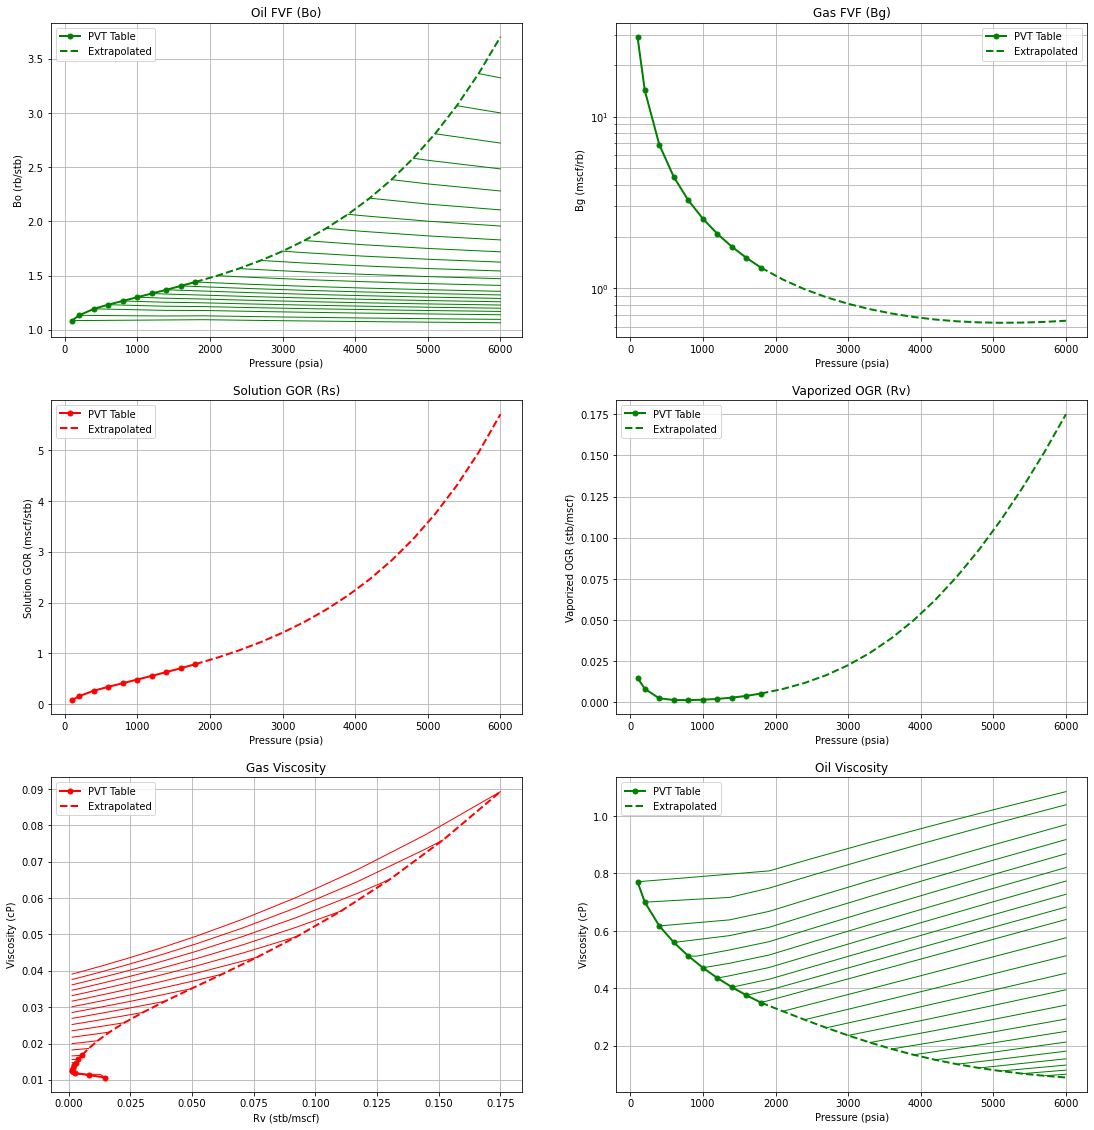

In [22]:
nx, ny = [2,3]
dxs, dys = [8.0, 5.5]                                                                                                                               
i = j = 0
fig, ax = plt.subplots(ny, nx, sharey = False, figsize=(dxs*nx, dys*ny), squeeze=False ) # squeeze = False ensures 2 x 1 does not get converted to 1D                                                                                
fig.subplots_adjust(top=0.95, bottom = 0.05, left = 0.05, right = 0.95)   

ax[i,j].title.set_text('Oil FVF (Bo)')
ax[i,j].plot(PVT['P'], PVT['Bo'], label='PVT Table', color='green', linewidth=2,marker='o',markersize=5)  
ax[i,j].plot(p_ext, Bo_ext, label='Extrapolated', color='green', linewidth=2,linestyle = '--') 
for p in psats:
    usat = ousat_dic[p]
    pusat = [x[0] for x in usat]
    Bo = [x[1] for x in usat]
    ax[i,j].plot(pusat, Bo, color='green', linewidth=1) 
ax[i,j].grid(True, which="both")                                                                                                              
ax[i,j].set_xlabel('Pressure (psia)')                                                                                        
ax[i,j].set_ylabel('Bo (rb/stb)')                                                                                                    
ax[i,j].legend() 

i, j = nextplot(i,j,nx)
ax[i,j].title.set_text('Gas FVF (Bg)')
ax[i,j].plot(PVT['P'], PVT['Bg'], label='PVT Table', color='green', linewidth=2,marker='o',markersize=5)  
ax[i,j].plot(p_ext, Bg_ext, label='Extrapolated', color='green', linewidth=2,linestyle = '--') 
ax[i,j].grid(True, which="both")                                                                                                              
ax[i,j].set_xlabel('Pressure (psia)')                                                                                        
ax[i,j].set_ylabel('Bg (mscf/rb)') 
ax[i,j].set_yscale('log')
ax[i,j].legend() 

i, j = nextplot(i,j,nx)
ax[i,j].title.set_text('Solution GOR (Rs)')
ax[i,j].plot(PVT['P'], PVT['Rs'], label='PVT Table', color='red', linewidth=2,marker='o',markersize=5)  
ax[i,j].plot(p_ext, Rs_ext, label='Extrapolated', color='red', linewidth=2,linestyle = '--') 
ax[i,j].grid(True, which="both")                                                                                                              
ax[i,j].set_xlabel('Pressure (psia)')                                                                                        
ax[i,j].set_ylabel('Solution GOR (mscf/stb)')                                                                                                    
ax[i,j].legend()                                                                                                                   

i, j = nextplot(i,j,nx)
ax[i,j].title.set_text('Vaporized OGR (Rv)')
ax[i,j].plot(PVT['P'], PVT['Rv'], label='PVT Table', color='green', linewidth=2,marker='o',markersize=5)  
ax[i,j].plot(p_ext, rs_ext, label='Extrapolated', color='green', linewidth=2,linestyle = '--') 
ax[i,j].grid(True, which="both")                                                                                                              
ax[i,j].set_xlabel('Pressure (psia)')                                                                                        
ax[i,j].set_ylabel('Vaporized OGR (stb/mscf)')                                                                                                    
ax[i,j].legend() 

i, j = nextplot(i,j,nx)
ax[i,j].title.set_text('Gas Viscosity')
ax[i,j].plot(PVT['Rv'], PVT['ug'], label='PVT Table', color='red', linewidth=2,marker='o',markersize=5)  
ax[i,j].plot(rs_ext, ug_ext, label='Extrapolated', color='red', linewidth=2,linestyle = '--') 
for p in psats:
    usat = gusat_dic[p]
    rs = [x[0] for x in usat]
    ug = [x[2] for x in usat]
    ax[i,j].plot(rs, ug, color='red', linewidth=1) 
ax[i,j].grid(True, which="both")
ax[i,j].set_xlabel('Rv (stb/mscf)') 
ax[i,j].set_ylabel('Viscosity (cP)')
ax[i,j].legend()
    
i, j = nextplot(i,j,nx)
ax[i,j].title.set_text('Oil Viscosity')
ax[i,j].plot(PVT['P'], PVT['uo'], label='PVT Table', color='green', linewidth=2,marker='o',markersize=5)  
ax[i,j].plot(p_ext, uo_ext, label='Extrapolated', color='green', linewidth=2,linestyle = '--') 
for p in psats:
    usat = ousat_dic[p]
    pusat = [x[0] for x in usat]
    uo = [x[2] for x in usat]
    ax[i,j].plot(pusat, uo, color='green', linewidth=1) 
ax[i,j].grid(True, which="both")                                                                                                              
ax[i,j].set_xlabel('Pressure (psia)')                                                                                        
ax[i,j].set_ylabel('Viscosity (cP)')                                                                                                    
ax[i,j].legend() 

plt.show()    


## Selective removal of Oil data points that appear anomalous - If Required
In this example, points 1-4 in the 100 psi line, 1-3 in the 200psi, 1-2 in the 400 psi and 1 in the 600 psi lines were be removed, then replotted above

In [21]:
# Oil, points to remove
table = []
header = ['Index','Saturated Pressure']
for i in range(len(psats)):
    table.append([i, psats[i]])
print(tabulate(table,headers=header))
idx = int(input('\nEnter index of undersaturated line to edit: (-1 to leave as-is): '))
if idx in range(len(psats)):
    clear_output()
    Psat = psats[idx]
    usat = ousat_dic[Psat]
    table = []
    header = ['Index','Pressure', 'Bo', 'uo']
    for i in range(len(usat)):
        table.append([i, usat[i][0], usat[i][1], usat[i][2]])
    print(tabulate(table,headers=header))
    idx = input('\nEnter index of undersaturated point(s) to remove separated by commas (-1 to leave as-is): ')
    if idx != '-1':
        if ',' in idx:
            idx = [int(x) for x in idx.split(',')]
        else:
            idx = [int(idx)]
        idx.sort(reverse=True)
        for i in idx:
            usat.pop(i)
        ousat_dic[Psat] = usat



  Index    Pressure       Bo        uo
-------  ----------  -------  --------
      0         600  1.23174  0.55985
      1         914  1.22517  0.549977
      2        1368  1.21769  0.583613
      3        1912  1.2142   0.612586
      4        2547  1.20514  0.662285
      5        3274  1.19599  0.718162
      6        4091  1.18695  0.779677
      7        5000  1.17812  0.84656
      8        5999  1.16963  0.918204

Enter index of undersaturated point(s) to remove separated by commas (-1 to leave as-is): 1


## Selective removal of Gas data points that appear anomalous - If required
Not used in this example

In [ ]:
# Gas, points to remove
table = []
header = ['Index','Saturated Pressure', 'Saturated Rv']
for i in range(len(psats)):
    table.append([i, psats[i], rss[i]])
print(tabulate(table,headers=header))
idx = int(input('\nEnter index of undersaturated line to edit: (-1 to leave as-is): '))
if idx in range(len(psats)):
    clear_output()
    Psat = psats[idx]
    ugsat = gusat_dic[Psat]
    table = []
    header = ['Index','Pressure', 'Bo', 'uo']
    for i in range(len(usat)):
        table.append([i, usat[i][0], usat[i][1], usat[i][2]])
    print(tabulate(table,headers=header))
    idx = input('\nEnter index of undersaturated point(s) to remove separated by commas (-1 to leave as-is): ')
    if idx != '-1':
        if ',' in idx:
            idx = [int(x) for x in idx.split(',')]
        else:
            idx = [int(idx)]
        idx.sort(reverse=True)
        for i in idx:
            usat.pop(i)
        ousat_dic[Psat] = usat



## Address retrograde CGR reversal at low pressures to ensure Eclipse doesn't throw an error with increasing CGR
Will achieve by simply truncating non-montonic saturated Rs to minimum seen, and removal of all associated understaurated lines

In [23]:
Min_rss = min(rss)
Min_idx = rss.index(Min_rss)
usat_rs = PVT['Rv'].tolist() # Editing this table as well so that plots reflect changes made
for i in range(Min_idx):
    if i < len(usat_rs)-1:
        usat_rs[i] = Min_rss
    rss[i] = Min_rss
    ugsat = gusat_dic[psats[i]]
    ugsat[0][0] = Min_rss # First element of first row is saturated Rv, overwrite with minimum
    while len(ugsat)>1: # recursivley remove understaurated lines
        ugsat.pop()
    gusat_dic[psats[i]] = ugsat # And put back in dictionary
PVT['Rv'] = usat_rs
    

## Generate Eclipse file format output

In [25]:
outfile = '-- =========================================================================\n-- Black Oil Table \n-- Extrapolated with method outlined in SPE 109596 (Singh & Whitson 2007)\n-- Implemented in Python by Mark Burgoyne, September 2020\n'
outfile += '-- =========================================================================\n'
outfile += 'DENSITY\n--  deno (lbm/ft3)  denw (lbm/ft3)      deng (lbm/ft3)\n--------------------  ----------------  ----------------\n'
outfile += '     '+str(ST_DENO)+'                 *                '+str(ST_DENG)+'  /\n\n'
outfile += 'PVTO\n'
header = ['-- Rs (Mscf/bbl)','Pres(psia)','Bo (rb/stb)','Visc (cp)']
table = []
for i, psat in enumerate(psats):
    uosat = ousat_dic[psat]
    table.append([round(Rss[i],5), round(psat,1), round(Bos[i],5), round(uos[i],5)])
    for j, row in enumerate(uosat):
        if round(row[0],1) == table[-1][1]:
            continue
        table.append(['', round(row[0],1), round(row[1],5), round(row[2],5)])
outfile += tabulate(table,headers=header)+'  /\n\n'
outfile += 'PVTG\n'
header = ['-- Pdew(psia)','rv(bbl/Mscf)','Bg(rb/Mscf)','Visc (cp)']
table = []
for i, psat in enumerate(psats):
    ugsat = gusat_dic[psat]
    table.append([round(psat,1), round(rss[i],5),round(Bgs[i],10), round(ugs[i],10)])
    for j, row in enumerate(ugsat):
        if j == 0:
            continue
        table.append(['', round(row[0],6), round(row[1],6), round(row[2],6)])
outfile += tabulate(table,headers=header)+'  /\n'
print(outfile)
table_out = open("EXTENDED_PVT.inc", "w")
table_out.write(outfile)
table_out.close()


-- =========================================================================
-- Black Oil Table 
-- Extrapolated with method outlined in SPE 109596 (Singh & Whitson 2007)
-- Implemented in Python by Mark Burgoyne, September 2020
-- =========================================================================
DENSITY
--  deno (lbm/ft3)  denw (lbm/ft3)      deng (lbm/ft3)
--------------------  ----------------  ----------------
     49.87                 *                0.0689  /

PVTO
-- Rs (Mscf/bbl)      Pres(psia)    Bo (rb/stb)    Visc (cp)
------------------  ------------  -------------  -----------
0.07947                      100        1.085        0.77114
                            1912        1.09326      0.80907
                            2547        1.08771      0.85522
                            3274        1.08199      0.90649
                            4091        1.07623      0.96222
                            5000        1.07052      1.02201
                          

## Re-plot

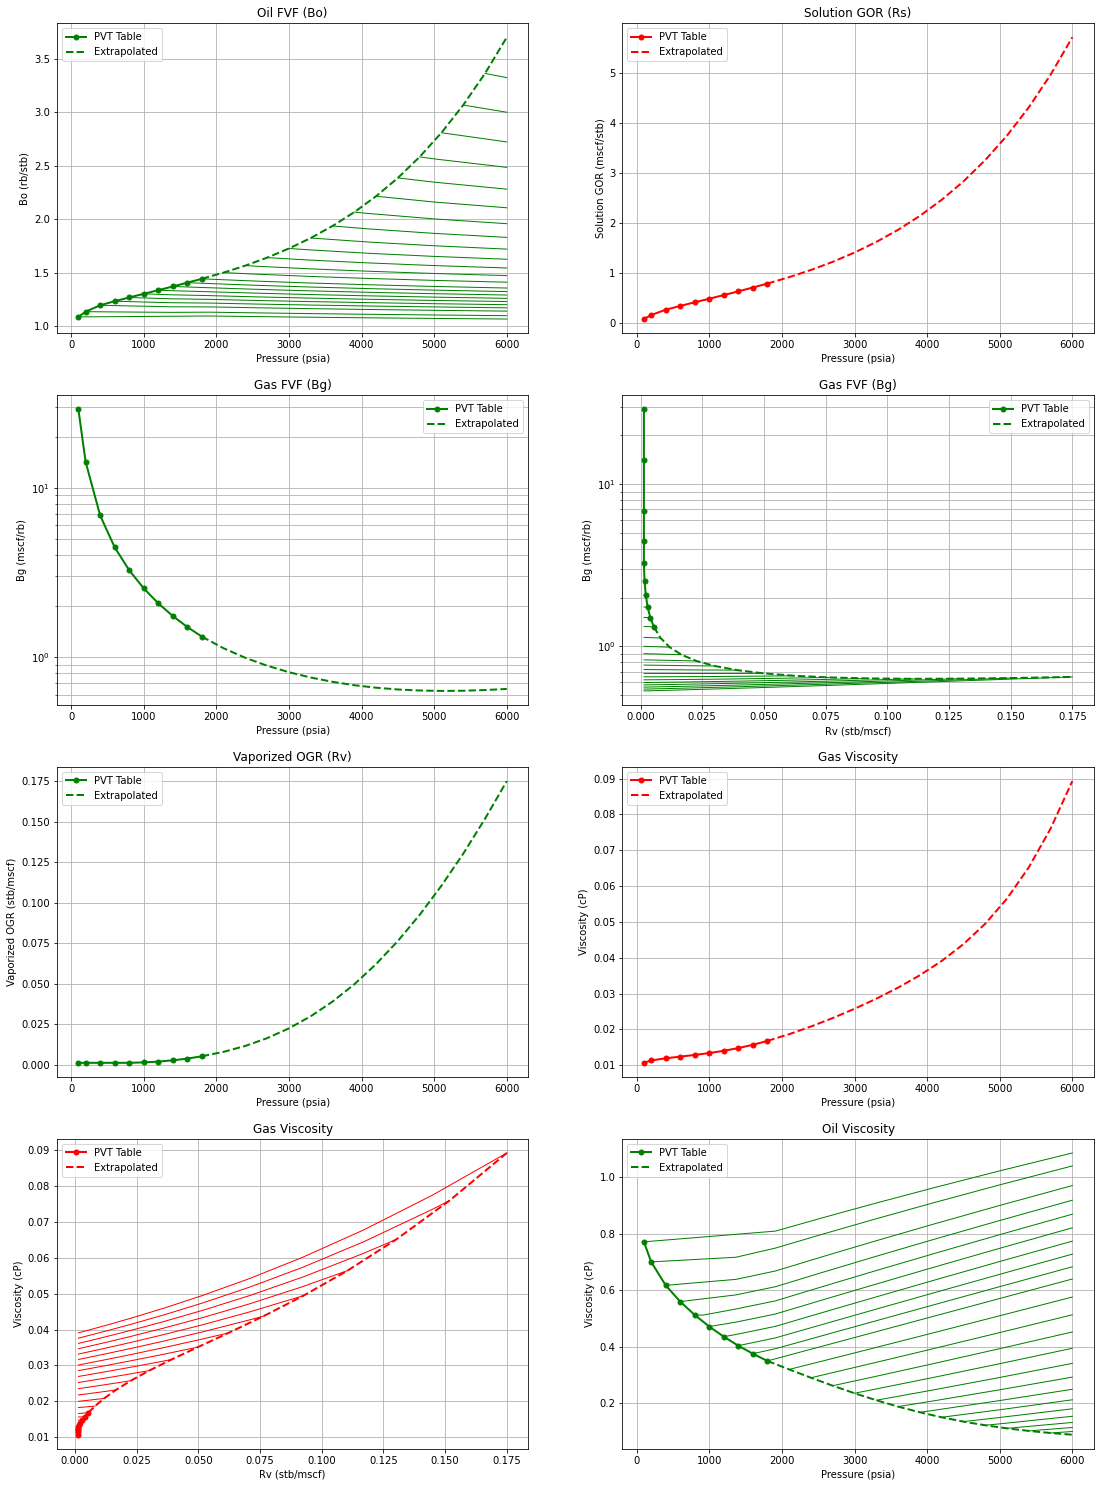

In [26]:
nx, ny = [2,4]
dxs, dys = [8.0, 5.5]                                                                                                                               
i = j = 0
fig, ax = plt.subplots(ny, nx, sharey = False, figsize=(dxs*nx, dys*ny), squeeze=False ) # squeeze = False ensures 2 x 1 does not get converted to 1D                                                                                
fig.subplots_adjust(top=0.95, bottom = 0.05, left = 0.05, right = 0.95)   

ax[i,j].title.set_text('Oil FVF (Bo)')
ax[i,j].plot(PVT['P'], PVT['Bo'], label='PVT Table', color='green', linewidth=2,marker='o',markersize=5)  
ax[i,j].plot(p_ext, Bo_ext, label='Extrapolated', color='green', linewidth=2,linestyle = '--') 
for p in psats:
    usat = ousat_dic[p]
    pusat = [x[0] for x in usat]
    Bo = [x[1] for x in usat]
    ax[i,j].plot(pusat, Bo, color='green', linewidth=1) 
ax[i,j].grid(True, which="both")                                                                                                              
ax[i,j].set_xlabel('Pressure (psia)')                                                                                        
ax[i,j].set_ylabel('Bo (rb/stb)')                                                                                                    
ax[i,j].legend() 

i, j = nextplot(i,j,nx)
ax[i,j].title.set_text('Solution GOR (Rs)')
ax[i,j].plot(PVT['P'], PVT['Rs'], label='PVT Table', color='red', linewidth=2,marker='o',markersize=5)  
ax[i,j].plot(p_ext, Rs_ext, label='Extrapolated', color='red', linewidth=2,linestyle = '--') 
ax[i,j].grid(True, which="both")                                                                                                              
ax[i,j].set_xlabel('Pressure (psia)')                                                                                        
ax[i,j].set_ylabel('Solution GOR (mscf/stb)')                                                                                                    
ax[i,j].legend()                               

i, j = nextplot(i,j,nx)
ax[i,j].title.set_text('Gas FVF (Bg)')
ax[i,j].plot(PVT['P'], PVT['Bg'], label='PVT Table', color='green', linewidth=2,marker='o',markersize=5)  
ax[i,j].plot(p_ext, Bg_ext, label='Extrapolated', color='green', linewidth=2,linestyle = '--') 
ax[i,j].grid(True, which="both")                                                                                                              
ax[i,j].set_xlabel('Pressure (psia)')                                                                                        
ax[i,j].set_ylabel('Bg (mscf/rb)') 
ax[i,j].set_yscale('log')
ax[i,j].legend() 

i, j = nextplot(i,j,nx)
ax[i,j].title.set_text('Gas FVF (Bg)')
ax[i,j].plot(PVT['Rv'], PVT['Bg'], label='PVT Table', color='green', linewidth=2,marker='o',markersize=5)  
ax[i,j].plot(rs_ext, Bg_ext, label='Extrapolated', color='green', linewidth=2,linestyle = '--') 
for p in psats:
    usat = gusat_dic[p]
    rs = [x[0] for x in usat]
    bg = [x[1] for x in usat]
    ax[i,j].plot(rs, bg, color='green', linewidth=1) 
ax[i,j].grid(True, which="both")                                                                                                              
ax[i,j].set_xlabel('Rv (stb/mscf)')                                                                                        
ax[i,j].set_ylabel('Bg (mscf/rb)') 
ax[i,j].set_yscale('log')
ax[i,j].legend()                                                                       

i, j = nextplot(i,j,nx)
ax[i,j].title.set_text('Vaporized OGR (Rv)')
ax[i,j].plot(PVT['P'], PVT['Rv'], label='PVT Table', color='green', linewidth=2,marker='o',markersize=5)  
ax[i,j].plot(p_ext, rs_ext, label='Extrapolated', color='green', linewidth=2,linestyle = '--') 
ax[i,j].grid(True, which="both")                                                                                                              
ax[i,j].set_xlabel('Pressure (psia)')                                                                                        
ax[i,j].set_ylabel('Vaporized OGR (stb/mscf)')                                                                                                    
ax[i,j].legend() 

i, j = nextplot(i,j,nx)
ax[i,j].title.set_text('Gas Viscosity')
ax[i,j].plot(PVT['P'], PVT['ug'], label='PVT Table', color='red', linewidth=2,marker='o',markersize=5)  
ax[i,j].plot(p_ext, ug_ext, label='Extrapolated', color='red', linewidth=2,linestyle = '--') 
ax[i,j].grid(True, which="both")
ax[i,j].set_xlabel('Pressure (psia)') 
ax[i,j].set_ylabel('Viscosity (cP)')
ax[i,j].legend()

i, j = nextplot(i,j,nx)
ax[i,j].title.set_text('Gas Viscosity')
ax[i,j].plot(PVT['Rv'], PVT['ug'], label='PVT Table', color='red', linewidth=2,marker='o',markersize=5)  
ax[i,j].plot(rs_ext, ug_ext, label='Extrapolated', color='red', linewidth=2,linestyle = '--') 
for p in psats:
    usat = gusat_dic[p]
    rs = [x[0] for x in usat]
    ug = [x[2] for x in usat]
    ax[i,j].plot(rs, ug, color='red', linewidth=1) 
ax[i,j].grid(True, which="both")
ax[i,j].set_xlabel('Rv (stb/mscf)') 
ax[i,j].set_ylabel('Viscosity (cP)')
ax[i,j].legend()
    
i, j = nextplot(i,j,nx)
ax[i,j].title.set_text('Oil Viscosity')
ax[i,j].plot(PVT['P'], PVT['uo'], label='PVT Table', color='green', linewidth=2,marker='o',markersize=5)  
ax[i,j].plot(p_ext, uo_ext, label='Extrapolated', color='green', linewidth=2,linestyle = '--') 
for p in psats:
    usat = ousat_dic[p]
    pusat = [x[0] for x in usat]
    uo = [x[2] for x in usat]
    ax[i,j].plot(pusat, uo, color='green', linewidth=1) 
ax[i,j].grid(True, which="both")                                                                                                              
ax[i,j].set_xlabel('Pressure (psia)')                                                                                        
ax[i,j].set_ylabel('Viscosity (cP)')                                                                                                    
ax[i,j].legend() 

plt.show()       
